In [1]:
from helpers_merging import *

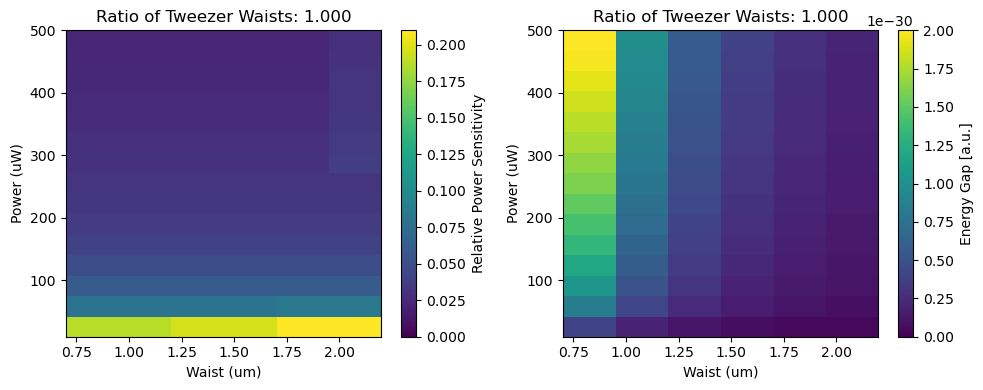

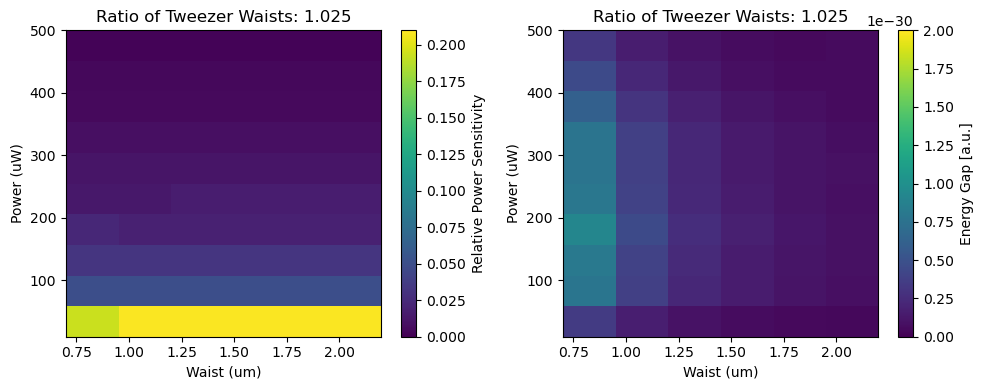

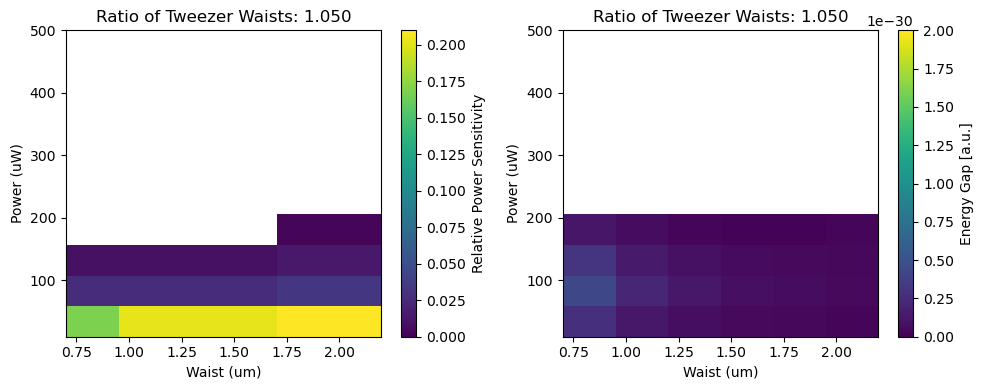

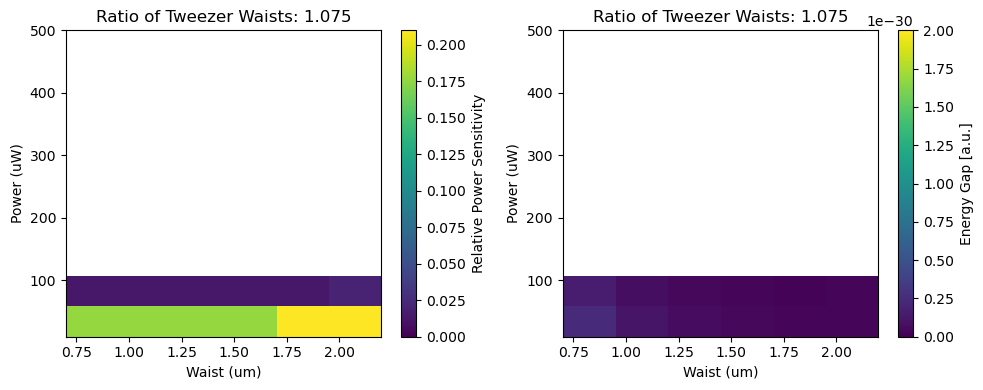

In [4]:
paths = np.array(["data/waist_ratio_1_highres.npz",
                  "data/waist_ratio_1025.npz",
                  "data/waist_ratio_105.npz",
                  "data/waist_ratio_1075.npz"])

for path in paths:
    data = np.load(path)

    for key in data.keys():
        globals()[key] = data[key]

    # Create the figure and two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # First plot (delta_power)
    cax1 = ax1.imshow(np.where(delta_power!=0,delta_power,np.nan) / initial_powers[:, np.newaxis], 
                    extent=[np.min(initial_waists) / si.uW, np.max(initial_waists) / si.uW, 
                            np.min(initial_powers) / si.um, np.max(initial_powers) / si.um], 
                    origin="lower", aspect="auto",vmin=0.,vmax=0.21)
    ax1.set_ylabel("Power (uW)")
    ax1.set_xlabel("Waist (um)")
    ax1.set_title(f"Ratio of Tweezer Waists: {factor_waist2:.3f}")
    fig.colorbar(cax1, ax=ax1, label="Relative Power Sensitivity")

    # Second plot (delta_E_max)
    cax2 = ax2.imshow(np.where(delta_E_max!=0,delta_E_max,np.nan), 
                    extent=[np.min(initial_waists) / si.uW, np.max(initial_waists) / si.uW, 
                            np.min(initial_powers) / si.um, np.max(initial_powers) / si.um], 
                    origin="lower", aspect="auto",vmin=0,vmax=2e-30)
    ax2.set_ylabel("Power (uW)")
    ax2.set_xlabel("Waist (um)")
    ax2.set_title(f"Ratio of Tweezer Waists: {factor_waist2:.3f}")
    fig.colorbar(cax2, ax=ax2, label="Energy Gap [a.u.]")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined figure
    plt.show()

## Make high res plot for waist ratio of 1:

In [15]:
from helpers_merging import *

initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 3*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist*1.02,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

x, y, z = trap.x, trap.y, trap.z

In [ ]:
def get_deltaE(power_tweezer1, power_tweezer2, waist_tweezer1, waist_tweezer2,
               n_levels=10,n_pot_steps=2000, initial_distance=4*si.um, plot=True):
    """
    Returns the minimal energy gap and occupation numbers of the groundstate when the two tweezers merge.
    """
    trap[trap.power_tweezer1] = power_tweezer1
    trap[trap.power_tweezer2] = power_tweezer2
    trap[trap.waist_tweezer1] = waist_tweezer1
    trap[trap.waist_tweezer2] = waist_tweezer2

    distances = np.linspace(initial_distance,0*si.um,500) #always has to have smallest distance at last index
    energies, states, potentials = loop_distances(trap, distances,n_levels=n_levels,n_pot_steps=n_pot_steps)

    new_energies, new_states, new_potentials, index_top, index, swap_index = swapped_loop_distance(distances, energies, states, potentials)
    energies_left, energies_right, states_left, states_right = find_ass_tweezer(new_energies,new_states, return_deltaE=False)

    if len(index)!=0:
        deltaE_min = 0
        print("crossover")
    else:
        deltaE_min = np.inf
        for i in range(energies_left.shape[1]):
            for j in range(energies_right.shape[1]):
                row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))
                if row_diff<deltaE_min:
                    deltaE_min = row_diff
                    i_min, j_min = i,j
        print(f"closest approach between states: left:{i_min}, right:{j_min}")

    if plot:
        # Create the figure with two subplots (1 row, 2 columns)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        # Plot the full range on ax1
        """
        ax1.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
        ax1.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
        ax1.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
        ax1.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
        ax1.plot(distances/si.um, energies_left[:], color="red", label="left tweezer")
        ax1.plot(distances/si.um, energies_right[:], color="blue", label="right tweezer")

        for i, ind in enumerate(index):
            ax1.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="energy crossings")

        ax1.set_xlabel("Tweezer distance [um]")
        ax1.set_ylabel("Eigenenergy [a.u.]")
        ax1.set_title(fr"$p_l={float(trap.subs(trap.power_tweezer1))/si.uW:.1f}$ uW, $p_r={float(trap.subs(trap.power_tweezer2))/si.uW:.1f}$ uW, $w_l={float(trap.subs(trap.waist_tweezer1))/si.um:.3f}$ um, $w_r={float(trap.subs(trap.waist_tweezer2))/si.um:.3f}$ um")
        ax1.grid()

        # Plot the zoomed-in range (1 to 1.5 µm) on ax2
        """
        ax2.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
        ax2.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
        ax2.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
        ax2.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
        ax2.plot(distances/si.um, energies_left[:], color="red", label="left tweezer")
        ax2.plot(distances/si.um, energies_right[:], color="blue", label="right tweezer")

        for i, ind in enumerate(index):
            ax2.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="energy crossings")

        ax2.set_xlabel("Tweezer distance [um]")
        ax2.set_ylabel("Eigenenergy [a.u.]")
        ax2.set_title("Zoomed-in Region")
        ax2.set_xlim(0.5*waist_tweezer1, 1.5*waist_tweezer1)  # Zooming in on the region between 1.0 and 1.5 µm
        #ax2.set_ylim(-7e-28,-5e-28)
        ax2.grid()

        # Remove duplicates in the legend (labels that appear in both subplots)
        handles, labels = ax1.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))  # Remove duplicates
        ax1.legend(unique_labels.values(), unique_labels.keys())

        # Show the plots
        plt.tight_layout()
        plt.show()

    return deltaE_min

In [17]:
def get_power_range(initial_power, initial_waist,factor_waist2, n_spacing=20,n_levels=10):
    """Calculates the range of powers where there occurs no level crossing."""
    level_spacings = np.linspace(0,1,n_spacing)
    delta_E = np.full(len(level_spacings),np.nan)

    trap[trap.power_tweezer1] = initial_power
    trap[trap.waist_tweezer1] = initial_waist
    trap[trap.waist_tweezer2] = initial_waist*factor_waist2

    omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

    #offset required for 1 level spacing of the left tweezer
    power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

    #factor to match trap depth and offset by half(or another fraction of) the level spacing
    power2_factor = factor_waist2**2 - level_spacings*float(trap.subs(power2_offset))/initial_power

    power2s = initial_power*power2_factor

    for i, power2 in enumerate(power2s):
        delta_E[i] = get_deltaE(initial_power,power2,initial_waist,initial_waist*factor_waist2,n_levels=n_levels,plot=False)

    mask = delta_E != 0
    if np.sum(mask) == 0:
        power_range = 0
    else:
        power_range = np.max(power2s[mask]) - np.min(power2s[mask])
    return power_range, np.nanmax(delta_E)

In [18]:
factor_waist2 = 1.0

initial_powers = np.linspace(10,500,15)*si.uW
initial_waists = np.linspace(0.7,2.2,6)*si.um
delta_power = np.full((len(initial_powers),len(initial_waists)),np.nan)
delta_E_max = np.full((len(initial_powers),len(initial_waists)),np.nan)

for i, pow in enumerate(initial_powers):
    for j, wai in enumerate(initial_waists):

        delta_power[i,j], delta_E_max[i,j] = get_power_range(pow,wai,factor_waist2,n_spacing=25)

np.savez('data/waist_ratio_1_highres.npz', initial_powers=initial_powers, initial_waists=initial_waists, delta_power=delta_power, delta_E_max=delta_E_max, factor_waist2=factor_waist2)


crossover


C:\Users\naeve\AppData\Local\Temp\ipykernel_11984\382801629.py:24: RuntimeWarning: All-NaN slice encountered
  row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))


closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach bet